# Кластеризация текстов

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


## Предобработка данных

In [3]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end='\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

In [4]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [5]:
# Проверим, что число документов осталось прежним
len(docs)

3903

## Векторизация текстов

In [8]:
# Установка пакета gensim
!pip install -U gensim

     |████████████████████████████████| 24.2 MB 7.6 MB/s eta 0:00:0101
     |████████████████████████████████| 119 kB 7.1 MB/s eta 0:00:01
Using legacy 'setup.py install' for smart-open, since package 'wheel' is not installed.
    Running setup.py install for smart-open ... done


In [9]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

<ipython-input-9-57cd6b3a200b>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc_vector = model[word]
<ipython-input-9-57cd6b3a200b>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc_vector = np.add(doc_vector, model[word])


In [10]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([-0.701467  , -1.117457  ,  0.59903866,  0.41441208, -0.9705107 ,
         1.1175339 ,  0.09894486,  0.58577436, -0.14813672,  0.1257562 ,
        -0.3103574 ,  0.68722445, -0.03966002,  1.0510159 ,  0.37030318,
         0.06439123, -1.3534198 ,  0.56175524,  0.04612648, -0.30589065,
        -0.34824702,  0.23979728,  0.03656841, -0.7851596 , -0.04898974,
         0.9015256 ,  0.31419745,  0.27383628,  0.25936562,  0.34866592,
        -0.44769943, -0.4131491 , -0.57644147,  0.02808925, -0.3601994 ,
         0.6770142 , -0.3425514 ,  0.57050407, -0.12104245, -0.21705395,
        -0.60771716, -0.3627759 , -0.50493073,  0.0063542 , -0.47560927,
        -1.4066406 ,  0.16313928, -0.21902223,  0.71031314, -0.34177136],
       dtype=float32),
 array([-0.11255267, -1.0944501 ,  0.5072401 ,  0.06474139, -0.5669707 ,
         0.31957805, -0.21450065, -0.2783921 , -0.11270469, -0.3571249 ,
        -0.23964036,  0.46939042, -0.16366692,  0.7847588 ,  0.44238776,
        -0.28855768, -0.850

In [11]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


In [12]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X = tsne.fit_transform(X)

print(np.asarray(X).shape)

(3903, 2)


## Кластеризация

In [13]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

KMeans(n_clusters=4)

In [14]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(np.int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[ 50.20488    10.734026 ]
 [-38.607235   -6.1952443]
 [-10.03001    42.91508  ]
 [ -1.000897  -38.611572 ]]


<ipython-input-14-49ac665cde34>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = kmeans.labels_.astype(np.int)


In [15]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.509
Однородность: 0.776
Полнота: 0.779
V-мера: 0.778


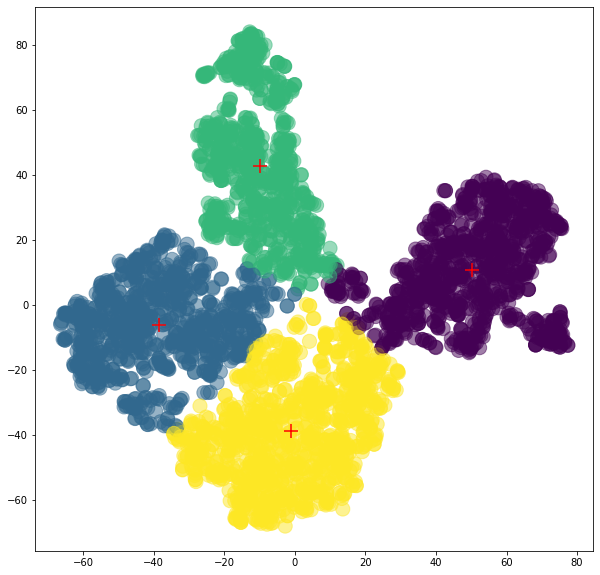

In [16]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

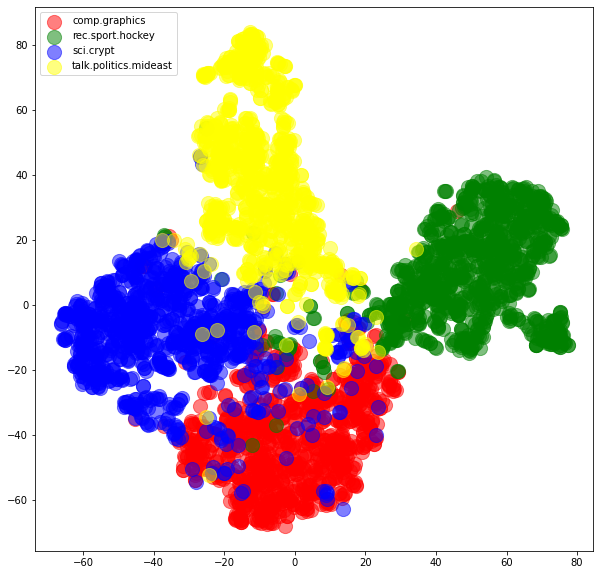

In [17]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=200, alpha=.5, c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.show()